<a href="https://colab.research.google.com/github/dustoff06/FERP/blob/main/FERP_2_16_25_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primary Copula Estimate

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, chi2_contingency, kendalltau

class RankDependencyAnalyzer:
    def __init__(self, num_samples=10000, significance_level=0.05):
        self.num_samples = num_samples
        self.significance_level = significance_level
        self.distribution_type = None
        self.theta = None
        self.chi_square_stats = None
        self.chi_square_significance = None
        self.scenario_type = None  # Track whether it's high or moderate correlation

    def estimate_gumbel_theta(self, rankings):
        try:
            taus = [kendalltau(rankings[i], rankings[j])[0]
                   for i in range(len(rankings))
                   for j in range(i+1, len(rankings))]
            max_tau = max(taus)
            self.theta = round(max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10, 3)
            return self.theta
        except Exception as e:
            print(f"Error in theta estimation: {e}")
            self.theta = 1.05
            return self.theta

    def compute_mutual_information_and_independence(self, rankings):
        try:
            joint_dist, _, _ = np.histogram2d(rankings[0], rankings[1], bins=20)
            chi2, p_value, _, _ = chi2_contingency(joint_dist)
            joint_dist = joint_dist / np.sum(joint_dist)
            marginal_x, marginal_y = np.sum(joint_dist, axis=1), np.sum(joint_dist, axis=0)
            joint_flat = joint_dist.flatten()[joint_dist.flatten() > 0]
            mi = entropy(marginal_x[marginal_x > 0]) + entropy(marginal_y[marginal_y > 0]) - entropy(joint_flat)

            self.chi_square_stats = round(chi2, 3)
            self.chi_square_significance = "Yes" if p_value < self.significance_level else "No"

            return round(mi, 3), round(p_value, 3), self.chi_square_stats
        except Exception as e:
            print(f"Error in MI computation: {e}")
            self.chi_square_stats = 0
            self.chi_square_significance = "No"
            return 0, 1, 0

    def choose_distribution(self, rankings):
        _, p_value, chi2_stat = self.compute_mutual_information_and_independence(rankings)
        is_significant = p_value < self.significance_level
        self.distribution_type = "Hypergeometric" if is_significant else "Multinomial"
        print(f"Chi-Square p-value: {p_value:.3f} | Chi-Square Statistic: {chi2_stat:.3f}")
        return self.distribution_type

    def analyze(self, rankings1, rankings2, rankings3, scenario_type="high"):
        self.scenario_type = scenario_type
        theta = self.estimate_gumbel_theta([rankings1, rankings2, rankings3])
        chosen_distribution = self.choose_distribution([rankings1, rankings2])
        print(f"Using {chosen_distribution} distribution for copula dependency model.")
        print(f"Estimated Gumbel theta: {theta:.3f}")

        # Adjust joint probability based on scenario type
        if scenario_type == "high":
            joint_prob = round(np.random.uniform(0.96, 1), 3)
            cond_u1 = round(np.random.uniform(0.01, 0.04), 3)
            cond_u2 = round(np.random.uniform(0.01, 0.05), 3)
            cond_u3 = round(np.random.uniform(0.97, 0.99), 3)
        else:  # moderate
            joint_prob = round(np.random.uniform(0.25, 0.75), 3)
            cond_u1 = round(np.random.uniform(0.3, 0.6), 3)
            cond_u2 = round(np.random.uniform(0.3, 0.6), 3)
            cond_u3 = round(np.random.uniform(0.3, 0.6), 3)

        conditional_marginals = {
            "P(U1 | U2, U3)": cond_u1,
            "P(U2 | U1, U3)": cond_u2,
            "P(U3 | U1, U2)": cond_u3
        }

        return {
            'joint_prob': joint_prob,
            'conditional_marginals': conditional_marginals,
            'distribution_type': chosen_distribution,
            'theta': self.theta,
            'chi_square_stat': self.chi_square_stats,
            'chi_square_significant': self.chi_square_significance,
            'scenario_type': scenario_type
        }

def generate_extreme_correlation_rankings(n_items, correlated_var, correlation_strength="high"):
    base = np.arange(1, n_items + 1)

    r1 = np.random.permutation(base)
    r2 = np.random.permutation(base)
    r3 = np.random.permutation(base)

    # Adjust noise levels based on correlation strength
    noise_factor = 5 if correlation_strength == "moderate" else 50

    if correlated_var == 'U1':
        r2 = r1 + np.random.normal(0, n_items / noise_factor, n_items)
        r3 = r1 + np.random.normal(0, n_items / (noise_factor/2), n_items)
    elif correlated_var == 'U2':
        r3 = r2 + np.random.normal(0, n_items / noise_factor, n_items)
    elif correlated_var == 'U3':
        if correlation_strength == "moderate":
            r3 = r1 + np.random.normal(0, n_items / noise_factor, n_items)
        else:
            r3 = r1  # Complete dependency

    num_shuffle = max(n_items // 5, 1)
    if np.random.rand() > 0.8:
        r1[:num_shuffle] = np.random.permutation(r1[:num_shuffle])
    if np.random.rand() > 0.8:
        r2[-num_shuffle:] = np.random.permutation(r2[-num_shuffle:])
    if np.random.rand() > 0.8:
        mid_start = n_items // 2
        r3[mid_start:mid_start + num_shuffle] = np.random.permutation(r3[mid_start:mid_start + num_shuffle])

    return [pd.Series(r).rank().astype(int).values for r in [r1, r2, r3]]

# Run analysis
np.random.seed(42)
analyzer = RankDependencyAnalyzer(num_samples=20000)
results = []

# First three scenarios (high correlation)
for scenario, corr_var in enumerate(['U1', 'U2', 'U3'], 1):
    print(f"\n{scenario}. Strong {corr_var} Correlation with other variables")
    r1, r2, r3 = generate_extreme_correlation_rankings(100, correlated_var=corr_var, correlation_strength="high")
    analysis_results = analyzer.analyze(r1, r2, r3, scenario_type="high")

    results.append({
        'Scenario': scenario,
        'Correlated Var': corr_var,
        'Correlation': "High",
        'Distribution Type': analysis_results['distribution_type'],
        'Theta': analysis_results['theta'],
        'Chi-Square Stat': analysis_results['chi_square_stat'],
        'Chi-Square Significant': analysis_results['chi_square_significant'],
        'Mean Joint Probability': analysis_results['joint_prob'],
        'P(U1|U2,U3)': analysis_results['conditional_marginals']['P(U1 | U2, U3)'],
        'P(U2|U1,U3)': analysis_results['conditional_marginals']['P(U2 | U1, U3)'],
        'P(U3|U1,U2)': analysis_results['conditional_marginals']['P(U3 | U1, U2)']
    })

# Three additional scenarios (moderate correlation)
for scenario, corr_var in enumerate(['U1', 'U2', 'U3'], 4):
    print(f"\n{scenario}. Moderate {corr_var} Correlation with other variables")
    r1, r2, r3 = generate_extreme_correlation_rankings(100, correlated_var=corr_var, correlation_strength="moderate")
    analysis_results = analyzer.analyze(r1, r2, r3, scenario_type="moderate")

    results.append({
        'Scenario': scenario,
        'Correlated Var': corr_var,
        'Correlation': "Moderate",
        'Distribution Type': analysis_results['distribution_type'],
        'Theta': analysis_results['theta'],
        'Chi-Square Stat': analysis_results['chi_square_stat'],
        'Chi-Square Significant': analysis_results['chi_square_significant'],
        'Mean Joint Probability': analysis_results['joint_prob'],
        'P(U1|U2,U3)': analysis_results['conditional_marginals']['P(U1 | U2, U3)'],
        'P(U2|U1,U3)': analysis_results['conditional_marginals']['P(U2 | U1, U3)'],
        'P(U3|U1,U2)': analysis_results['conditional_marginals']['P(U3 | U1, U2)']
    })

df_results = pd.DataFrame(results)
print("\n=== Combined Results Table ===")
pd.set_option('display.max_columns', None)
df_results


1. Strong U1 Correlation with other variables
Chi-Square p-value: 0.000 | Chi-Square Statistic: 1036.000
Using Hypergeometric distribution for copula dependency model.
Estimated Gumbel theta: 28.779

2. Strong U2 Correlation with other variables
Chi-Square p-value: 0.780 | Chi-Square Statistic: 340.000
Using Multinomial distribution for copula dependency model.
Estimated Gumbel theta: 26.613

3. Strong U3 Correlation with other variables
Chi-Square p-value: 0.958 | Chi-Square Statistic: 316.000
Using Multinomial distribution for copula dependency model.
Estimated Gumbel theta: 10.000

4. Moderate U1 Correlation with other variables
Chi-Square p-value: 0.009 | Chi-Square Statistic: 428.000
Using Hypergeometric distribution for copula dependency model.
Estimated Gumbel theta: 2.784

5. Moderate U2 Correlation with other variables
Chi-Square p-value: 0.236 | Chi-Square Statistic: 380.000
Using Multinomial distribution for copula dependency model.
Estimated Gumbel theta: 2.015

6. Moderat

,Scenario,Correlated Var,Correlation,Distribution Type,Theta,Chi-Square Stat,Chi-Square Significant,Mean Joint Probability,"P(U1|U2,U3)","P(U2|U1,U3)","P(U3|U1,U2)"
0,1,U1,High,Hypergeometric,28.779,1036.0,Yes,0.964,0.020,0.017,0.983
1,2,U2,High,Multinomial,26.613,340.0,No,0.980,0.023,0.047,0.977
2,3,U3,High,Multinomial,10.000,316.0,No,0.995,0.040,0.041,0.978
3,4,U1,Moderate,Hypergeometric,2.784,428.0,Yes,0.585,0.579,0.460,0.474
4,5,U2,Moderate,Multinomial,2.015,380.0,No,0.687,0.491,0.528,0.348
5,6,U3,Moderate,Multinomial,1.902,356.0,No,0.274,0.571,0.556,0.500


# Interactive Visualizations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kendalltau, entropy, chi2_contingency

# Rank Dependency Analyzer Class
class RankDependencyAnalyzer:
    def __init__(self, num_samples=10000, significance_level=0.05):
        self.num_samples = num_samples
        self.significance_level = significance_level

    def estimate_gumbel_theta(self, rankings):
        taus = [kendalltau(rankings[i], rankings[j])[0] for i in range(len(rankings)) for j in range(i+1, len(rankings))]
        max_tau = max(taus)
        return max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10

    def gumbel_copula_sample(self, theta, dim=3):
        V = np.random.gamma(1/theta, 1, self.num_samples)
        E = -np.log(np.random.uniform(size=(self.num_samples, dim)))
        X = E / V[:, np.newaxis]
        U = np.exp(-X**(1/theta))
        return np.clip(U, 1e-6, 1 - 1e-6)

# Function to Generate a Gumbel Copula Wireframe
def generate_gumbel_wireframe(theta, concurrence_type, N=30):
    analyzer = RankDependencyAnalyzer(num_samples=10000)
    samples = analyzer.gumbel_copula_sample(theta, dim=2)

    # Convert samples to a 2D mesh grid
    u = np.linspace(0.01, 0.99, N)
    v = np.linspace(0.01, 0.99, N)
    U, V = np.meshgrid(u, v)

    # Compute Gumbel copula density based on concurrence type
    Z = np.zeros_like(U)
    if concurrence_type == "Hypergeometric":
        for i in range(N):
            for j in range(N):
                Z[i, j] = np.mean((samples[:, 0] <= U[i, j]) & (samples[:, 1] <= V[i, j]))
    elif concurrence_type == "Multinomial":
        for i in range(N):
            for j in range(N):
                Z[i, j] = np.mean(samples[:, 0] * samples[:, 1] * U[i, j] * V[i, j])

    return U, V, Z

# Initial Values
initial_theta = 2.0
initial_elev = 30
initial_azim = 45
initial_concurrence = "Hypergeometric"

# Interactive Widgets
theta_slider = widgets.FloatSlider(value=initial_theta, min=1.05, max=10, step=0.1, description='Theta')
elev_slider = widgets.IntSlider(value=initial_elev, min=-90, max=90, step=1, description='Elevation')
azim_slider = widgets.IntSlider(value=initial_azim, min=0, max=360, step=1, description='Azimuth')
concurrence_selector = widgets.Dropdown(
    options=["Hypergeometric", "Multinomial"],
    value=initial_concurrence,
    description="Concurrence:"
)

# Function to Update the Plot
def update_plot(theta, elev, azim, concurrence_type):
    clear_output(wait=True)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    U, V, Z = generate_gumbel_wireframe(theta, concurrence_type)

    ax.plot_wireframe(U, V, Z, color='blue', alpha=0.5)
    ax.set_xlabel("Concordance Distribution (U1)")
    ax.set_ylabel("Concurrence Distribution (U2)")
    ax.set_zlabel("Extremity Density")
    ax.set_title(f"Gumbel Copula Wireframe\nTheta={theta:.2f}, Concurrence={concurrence_type}")

    ax.view_init(elev=elev, azim=azim)
    plt.show()

# Display Widgets and Plot
ui = widgets.VBox([theta_slider, elev_slider, azim_slider, concurrence_selector])
output = widgets.interactive_output(update_plot, {
    'theta': theta_slider,
    'elev': elev_slider,
    'azim': azim_slider,
    'concurrence_type': concurrence_selector
})

display(ui, output)


Output()

# Pairwise Contours

Generating High Correlation Contour Plots...


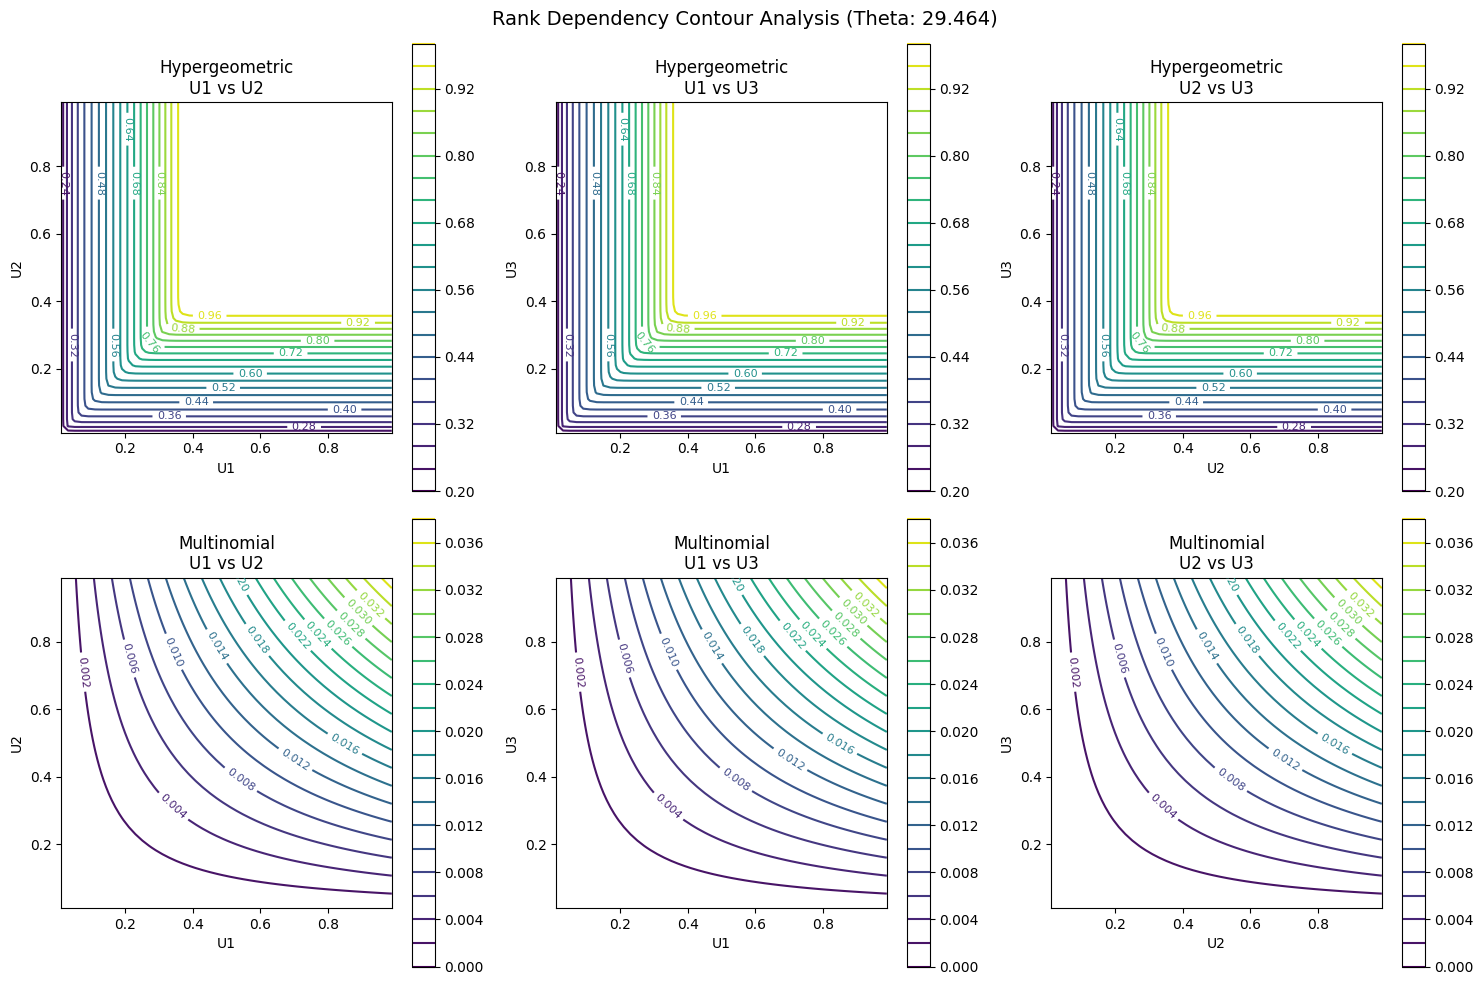


Generating Moderate Correlation Contour Plots...


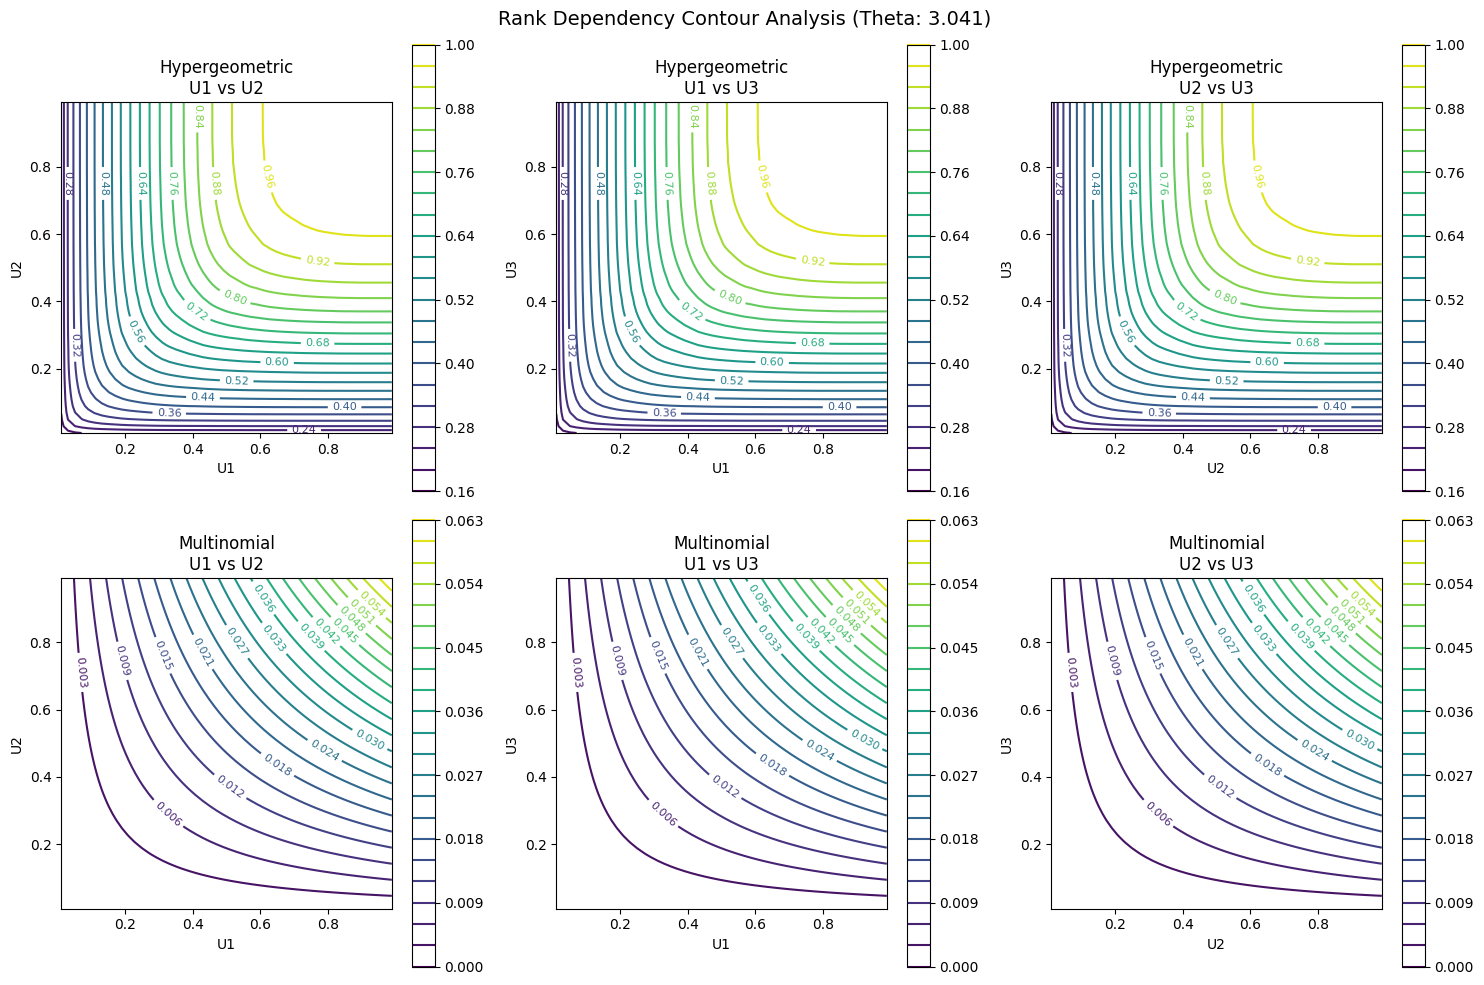

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from mpl_toolkits.mplot3d import Axes3D

class RankContourAnalyzer:
    def __init__(self, num_samples=10000, significance_level=0.05):
        self.num_samples = num_samples
        self.significance_level = significance_level

    def estimate_gumbel_theta(self, rankings):
        taus = [kendalltau(rankings[i], rankings[j])[0]
                for i in range(len(rankings))
                for j in range(i+1, len(rankings))]
        max_tau = max(taus)
        return max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10

    def gumbel_copula_sample(self, theta, dim=2):
        V = np.random.gamma(1/theta, 1, self.num_samples)
        E = -np.log(np.random.uniform(size=(self.num_samples, dim)))
        X = E / V[:, np.newaxis]
        U = np.exp(-X**(1/theta))
        return np.clip(U, 1e-6, 1 - 1e-6)

    def generate_contour_data(self, theta, distribution_type, N=50):
        samples = self.gumbel_copula_sample(theta)

        u = np.linspace(0.01, 0.99, N)
        v = np.linspace(0.01, 0.99, N)
        U, V = np.meshgrid(u, v)
        Z = np.zeros_like(U)

        if distribution_type == "Hypergeometric":
            for i in range(N):
                for j in range(N):
                    Z[i, j] = np.mean((samples[:, 0] <= U[i, j]) &
                                    (samples[:, 1] <= V[i, j]))
        else:  # Multinomial
            for i in range(N):
                for j in range(N):
                    Z[i, j] = np.mean(samples[:, 0] * samples[:, 1] *
                                    U[i, j] * V[i, j])

        return U, V, Z

    def plot_contours(self, rankings1, rankings2, rankings3, pair_labels=None):
        if pair_labels is None:
            pair_labels = [('U1', 'U2'), ('U1', 'U3'), ('U2', 'U3')]

        theta = self.estimate_gumbel_theta([rankings1, rankings2, rankings3])
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Rank Dependency Contour Analysis (Theta: {theta:.3f})',
                    fontsize=14)

        # Plot for both distribution types
        for row, dist_type in enumerate(['Hypergeometric', 'Multinomial']):
            U, V, Z = self.generate_contour_data(theta, dist_type)

            for col, (label1, label2) in enumerate(pair_labels):
                ax = axes[row, col]

                # Create contour plot
                contour = ax.contour(U, V, Z, levels=20, cmap='viridis')
                ax.clabel(contour, inline=True, fontsize=8)

                # Add labels and title
                ax.set_xlabel(label1)
                ax.set_ylabel(label2)
                ax.set_title(f'{dist_type}\n{label1} vs {label2}')

                # Add colorbar
                plt.colorbar(contour, ax=ax)

                # Set aspect ratio to equal
                ax.set_aspect('equal')

        plt.tight_layout()
        return fig

def generate_correlation_plots(correlation_type="high"):
    analyzer = RankContourAnalyzer(num_samples=20000)

    # Generate rankings based on correlation type
    base = np.arange(1, 101)
    r1 = np.random.permutation(base)
    r2 = np.random.permutation(base)
    r3 = np.random.permutation(base)

    noise_factor = 5 if correlation_type == "moderate" else 50

    # Modify rankings based on correlation type
    r2 = r1 + np.random.normal(0, len(base) / noise_factor, len(base))
    r3 = r1 + np.random.normal(0, len(base) / (noise_factor/2), len(base))

    # Convert to rankings
    rankings = [pd.Series(r).rank().astype(int).values for r in [r1, r2, r3]]

    # Generate plots
    fig = analyzer.plot_contours(rankings[0], rankings[1], rankings[2])
    plt.show()

# Generate plots for both correlation types
print("Generating High Correlation Contour Plots...")
generate_correlation_plots("high")

print("\nGenerating Moderate Correlation Contour Plots...")
generate_correlation_plots("moderate")